In [1]:
import networkx as nx
import dwave_networkx as dnx
import matplotlib.pyplot as plt
import random
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import dwave.inspector
from pyqubo import Spin
import neal
import time
import numpy as np
import pandas as pd
from greedy import SteepestDescentSolver
from pyvis.network import Network

# Make refference to a individual cell in DWave QPU arquitecture

We know:
- qubit = (a,b,c,d)
- If a=0 we reffer to horizontal part of Pegasus-cell, and if a=1, we reffer to the vertical part.
- For a=0:
  - b=0  == 1. c=(0-3) cell incompleted // 2. c=(0,1) qubit does not exist
  - b=15 == 1. c=(4-11) cell incomplete // 2. c=(10,11) qubit does not exist
- For a=1:
  - b=0  == 1. c=(0-7) cell incomplete // 2. c=(0,1) qubit does not exist
  - b=15 == 1. c=(8-11) cell incomplete // 2. c=(10,11) qubit does not exist
- - 0 < a < 1
  - 0 < b < 15
  - 0 < c < 11
  - 0 < d < 14
- All row counting starts from top-left corner

#### Make refference to the Horizontal or Vertical qubits cell

In [2]:
def horizontal(cell_x, row): #Cell=1 makes refference to the first complete cell in the QPU (in x axis)
    cell_x+=1 #Para que la primera cell cuando se llame sea la 0
    coord=[]
    
    if row<15:
        b_x=(cell_x*4)//12
        c_x=cell_x*4-b_x*12
        row_x=row-(cell_x-1)//3 #Cada 3 celdas que avanzas se debe retroceder una row (se agrega otra cell en la linea)
        for i in range(c_x,c_x+4):
            coord.append((0,b_x,i,row_x))
            
    else:
        cell_x=cell_x+(row-14)*3
        
        b_x=(cell_x*4)//12
        c_x=cell_x*4-b_x*12
        row_x=row-(cell_x-1)//3 #Cada 3 celdas que avanzas se debe retroceder una row (se agrega otra cell en la linea)
        for i in range(c_x,c_x+4):
            coord.append((0,b_x,i,row_x))
    
    coords = dnx.pegasus_coordinates(16)
    
    return list(coords.iter_pegasus_to_linear(coord))

In [3]:
def vertical(cell_x, row): #Cell=1 makes refference to the first complete cell in the QPU (in y axis)
    cell_x+=1
    coord=[]
    
    if row<15:
        cell_y=3*(row+1)-cell_x+2
        b_y=(cell_y*4)//12
        c_y=cell_y*4-b_y*12
        row_y=row-(cell_y-2)//3 #Cada 3 celdas que avanzas se debe retroceder una row (se agrega otra cell en la linea)
        for i in range(c_y,c_y+4):
            coord.append((1,b_y,i,row_y))
    else:
        cell_x=cell_x+(row-14)*3
        
        cell_y=3*(row+1)-cell_x+2
        b_y=(cell_y*4)//12
        c_y=cell_y*4-b_y*12
        row_y=row-(cell_y-2)//3 #Cada 3 celdas que avanzas se debe retroceder una row (se agrega otra cell en la linea)
        for i in range(c_y,c_y+4):
            coord.append((1,b_y,i,row_y))
    
    coords = dnx.pegasus_coordinates(16)
    
    return list(coords.iter_pegasus_to_linear(coord))

#### Make refference to an individual cell

In [4]:
def cell(cell_x,row):
    coord=[]
    cell_x+=1 #Para que la primera cell cuando se llame sea la 0
    if row<15:
        b_x=(cell_x*4)//12
        c_x=cell_x*4-b_x*12
        row_x=row-(cell_x-1)//3 #Cada 3 celdas que avanzas se debe retroceder una row (se agrega otra cell en la linea)
        for i in range(c_x,c_x+4):
            coord.append((0,b_x,i,row_x))
        
        cell_y=3*(row+1)-cell_x+2
        b_y=(cell_y*4)//12
        c_y=cell_y*4-b_y*12
        row_y=row-(cell_y-2)//3 #Cada 3 celdas que avanzas se debe retroceder una row (se agrega otra cell en la linea)
        for i in range(c_y,c_y+4):
            coord.append((1,b_y,i,row_y))
    else:
        cell_x=cell_x+(row-14)*3
        
        b_x=(cell_x*4)//12
        c_x=cell_x*4-b_x*12
        row_x=row-(cell_x-1)//3 #Cada 3 celdas que avanzas se debe retroceder una row (se agrega otra cell en la linea)
        for i in range(c_x,c_x+4):
            coord.append((0,b_x,i,row_x))
        
        cell_y=3*(row+1)-cell_x+2
        b_y=(cell_y*4)//12
        c_y=cell_y*4-b_y*12
        row_y=row-(cell_y-2)//3 #Cada 3 celdas que avanzas se debe retroceder una row (se agrega otra cell en la linea)
        for i in range(c_y,c_y+4):
            coord.append((1,b_y,i,row_y))

    coords = dnx.pegasus_coordinates(16)
    
    return list(coords.iter_pegasus_to_linear(coord))    

#### Try both functions

[120, 135, 150, 165, 3060, 3075, 3090, 3105]
[540, 555, 570, 585, 5582, 5597, 5612, 5627]
{120: (0, 0, 8, 0), 135: (0, 0, 9, 0), 150: (0, 0, 10, 0), 165: (0, 0, 11, 0), 3060: (1, 1, 0, 0), 3075: (1, 1, 1, 0), 3090: (1, 1, 2, 0), 3105: (1, 1, 3, 0), 540: (0, 3, 0, 0), 555: (0, 3, 1, 0), 570: (0, 3, 2, 0), 585: (0, 3, 3, 0), 5582: (1, 15, 0, 2), 5597: (1, 15, 1, 2), 5612: (1, 15, 2, 2), 5627: (1, 15, 3, 2)}


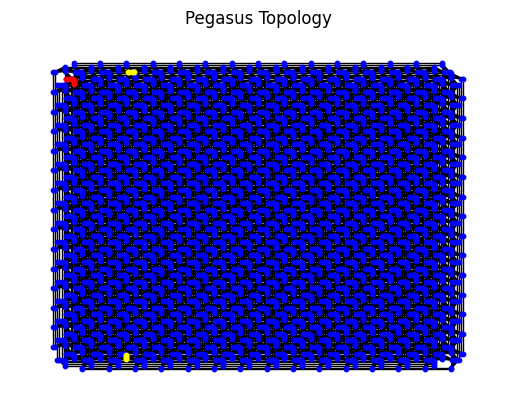

In [22]:
C16 = dnx.pegasus_graph(16)
pos = dnx.pegasus_layout(C16)
coords = dnx.pegasus_coordinates(16)

#Identify individual cell
nodes_cell=cell(1,0) #First value is the cell (axis "x"), Second value is the row (axis "y"). Both values starts at 0!
#Identify vertical or horizontal cell part
nodes_hv=horizontal(8,2)+vertical(1,16)
print(nodes_cell)
print(nodes_hv)

nodes_coord={n: coords.linear_to_pegasus(n) for n in nodes_cell+nodes_hv}
print(nodes_coord)

A = dnx.pegasus_graph(16, node_list=nodes_cell)
posA =  dnx.pegasus_layout(A)
B = dnx.pegasus_graph(16, node_list=nodes_hv)
posB =  dnx.pegasus_layout(B)

fig, ax = plt.subplots()
nx.draw(C16, pos, with_labels=False, node_size=10, font_size=4, linewidths=1, node_color='blue', font_color='black', font_weight='bold')
nx.draw(A, posA, node_size=10, font_size=4, linewidths=1, node_color='red')
nx.draw(B, posB, node_size=10, font_size=4, linewidths=1, node_color='yellow')
plt.title('Pegasus Topology')
plt.show()

### Verify we reffer to the correct cell with the dwave.inspector

In [21]:
h={n: 0.25 for n in nodes_cell}
J={}
edge=DWaveSampler().edgelist
for n in nodes_cell:
    for i in nodes_cell:
        if (n,i) not in J and ((n,i) in edge or (i,n) in edge):
            J[(n,i)]=0.25

embedding={q: [q] for q in nodes_cell}

In [18]:
num_read=1
secure_q = input("Do you really want to use the QPU? (y/n)")
if secure_q == 'y' or secure_q == 'Y':
    sampler = FixedEmbeddingComposite(DWaveSampler(solver=dict(topology__type='pegasus'), token='DEV-291d80af600d6eb433a8019c579070ba37436e9a'), embedding=embedding)
    sample_set = sampler.sample_ising(h, J, num_reads=num_read, return_embedding=True)
    print("Using DWaveSampler()")
    print(sample_set)

Do you really want to use the QPU? (y/n) y


Using DWaveSampler()
  2594 2609 2624 2639 5654 5669 5684 5699 energy num_oc. chain_.
0   -1   -1   -1   -1   +1   +1   +1   +1   -6.0       1     0.0
['SPIN', 1 rows, 1 samples, 8 variables]


In [20]:
dwave.inspector.show(sample_set)

Serving Inspector on http://127.0.0.1:18000/?problemId=77030b04-a704-4d5e-afa0-4baf5b73c326

'http://127.0.0.1:18000/?problemId=77030b04-a704-4d5e-afa0-4baf5b73c326'